In [9]:
import yolov5
import requests
import cv2
import time
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import torch
torch.backends.nnpack.enabled = False

In [10]:
def download_image(image_link: str, image_name) -> str:
    response = requests.get(image_link)
    with open(image_name, "wb") as f:
        f.write(response.content)
    return image_name    

In [11]:
# set image

images = [
    'https://tablica-rejestracyjna.pl/images/photos/20241222194356.jpeg',
    "https://tablica-rejestracyjna.pl/images/photos/20241221145937.jpg" ,
    "https://tablica-rejestracyjna.pl/images/photos/20241220211840_1.jpeg",
    "https://tablica-rejestracyjna.pl/images/photos/20241226000931.png",
    'https://tablica-rejestracyjna.pl/images/photos/20241222132622.jpg',
    'https://tablica-rejestracyjna.pl/images/photos/20241223133614.jpg',
]

imagesLoaded = []
for i, image in enumerate(images):
    img_filename = download_image(image, "downloaded_image_{}.jpg".format(i))
    imagesLoaded.append(cv2.imread(img_filename))



In [12]:
# load model
model = yolov5.load('keremberke/yolov5m-license-plate')
  
# set model parametes
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

In [13]:
tstart = time.time()
results = []
for img in imagesLoaded:
    results.append(model(img, size=640))
    
print("inference time", time.time() - tstart)

/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWar

inference time 0.43134260177612305


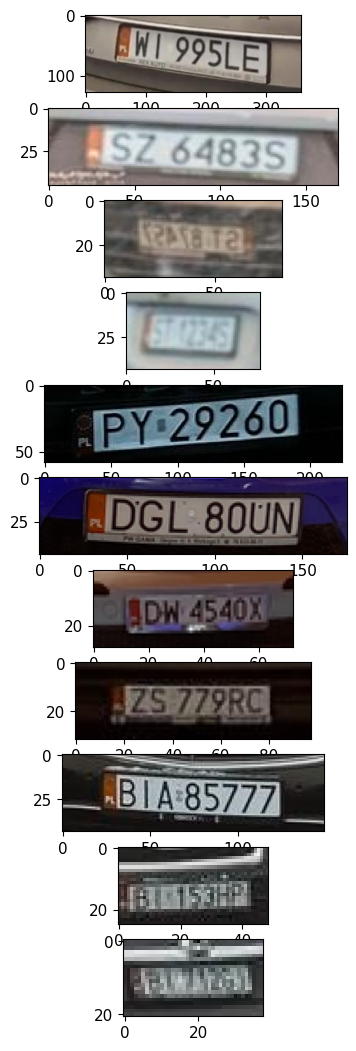

In [121]:
skewed_plates = []

for image, res in zip(imagesLoaded, results):
    predictions = res.pred[0]
    boxes = predictions[:, :4] # x1, y1, x2, y2
    scores = predictions[:, 4]
    categories = predictions[:, 5]

    for i, box in enumerate(boxes):
        box = [int(x) for x in box]
        x1, y1, x2, y2 = box
        #print(x1, y1, x2, y2)
        if(x1 > x2):
            x2, x1 = x1, x2
        if(y1 > y2):
            y2, y1 = y1, y2

        margin = 0.2
        w = x2 - x1 
        h = y2 - y1 
        dw = int(margin * w)
        dh = int(margin * h)


        x2 += dw 
        x1 -= dw

        y2 += dh
        y1 -= dh


        reg = image[y1:y2, x1:x2]

        #kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
        #reg = cv2.filter2D(reg, -1, kernel) 
        

        skewed_plates.append(reg.copy())


#boxes = np.matrix(boxes)

fig, axs = plt.subplots(len(skewed_plates))
for i, reg in enumerate(skewed_plates):
    #print(reg)
    axs[i].imshow(reg)

plt.show()




11


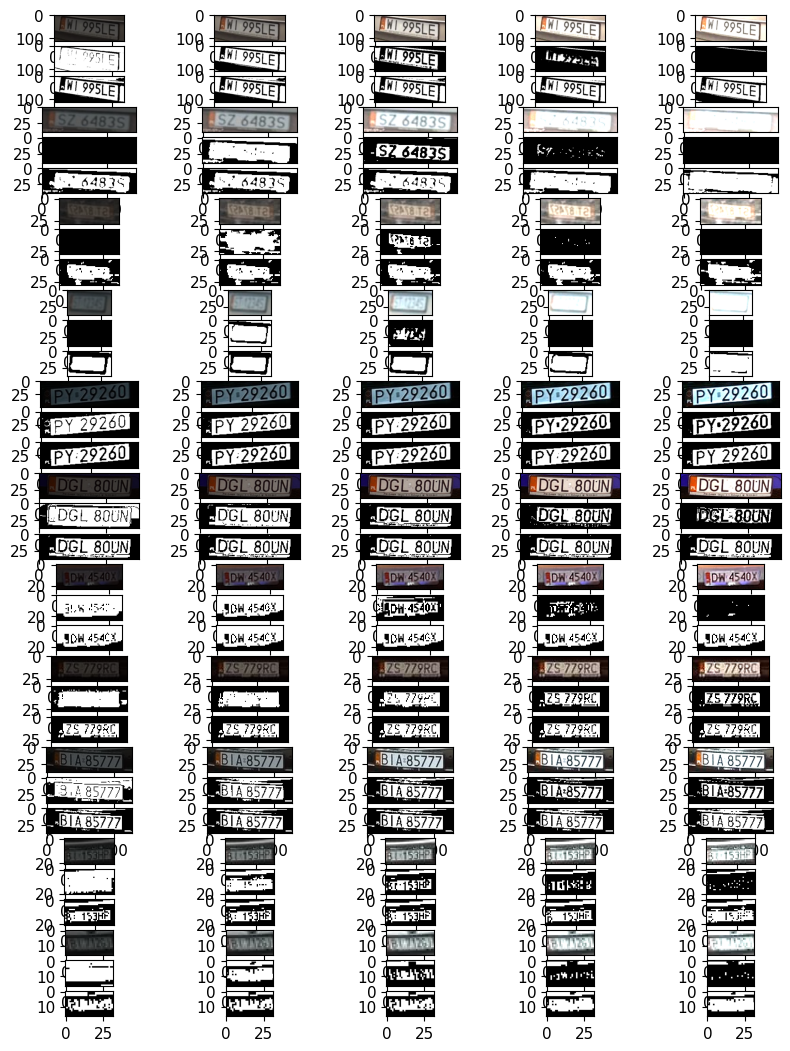

In [119]:

plt.rcParams["figure.figsize"] = (10, 13)

fig, axs = plt.subplots(len(skewed_plates)*3, 5)
print(len(skewed_plates))

enchanced = []

for i, plate in enumerate(skewed_plates):
    plate = plate.copy()
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    # 0.8, 1.0, 1.2, 1.4, 1.6
    for j in range(5):
        adjusted = cv2.convertScaleAbs(plate, alpha=0.4 + 0.4 * j, beta=1)
        gray = cv2.cvtColor(adjusted, cv2.COLOR_BGR2GRAY)
        
        #thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        #                                  cv2.THRESH_BINARY, 15, 0) 
        center = np.mean(gray)
        thresh2 = np.zeros_like(plate)
        thresh2 = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        thresh2[thresh2 > (center)] = 255
        thresh2[thresh2 != 255] = 0


        _, otsu = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        #output = np.zeros_like(plate)
        #output = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        #center = np.mean(output)
        #output[output > (center)] = 255
        #output[output != 255] = 0

        axs[i*3, j].imshow(adjusted.copy())
        axs[i*3+1, j].imshow(thresh2, cmap='gray')
        axs[i*3+2, j].imshow(otsu, cmap='gray')

        #axs[i*2+1, j].imshow(adjusted)
        

11
297
49
19
21
85
51
13
21
43
7
5


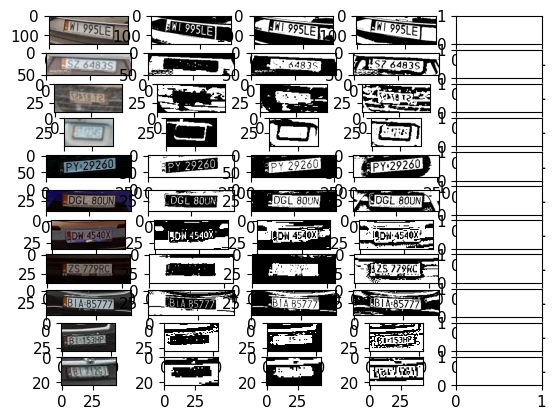

In [79]:

fig, axs = plt.subplots(len(skewed_plates), 5)
print(len(skewed_plates))

enchanced = []

for i, plate in enumerate(skewed_plates):
    plate = plate.copy()
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    #plate = cv2.GaussianBlur(plate,(5,5),0)
    hsv_image = cv2.cvtColor(plate, cv2.COLOR_BGR2HSV)
    center = cv2.mean(plate)[0]
    d = 30
    low = center - d
    high = center + d   
    
    
    #mask = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    mask = cv2.cvtColor(plate, cv2.COLOR_RGB2GRAY)
    mask = cv2.inRange(mask, 0, center/1.2)
    #mask = cv2.bitwise_not(mask)
    #plate = cv2.bitwise_not(plate)
    #output = cv2.bitwise_or(plate, plate, mask = mask)
    blockSize = max(int(plate.shape[0] * plate.shape[1] / 200), 3)

    blockSize = blockSize if blockSize % 2 == 1 else blockSize +1
    print(blockSize)
    thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, blockSize, 5) 
    
    adjusted = cv2.convertScaleAbs(plate, alpha=0.1, beta=0.8)

    # make output be binary version of plate
    output = np.zeros_like(plate)
    output = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    output[output > (center)] = 255
    output[output != 255] = 0



    enchanced.append(output)

    axs[i, 0].imshow(plate)
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 2].imshow(output, cmap='gray')
    axs[i, 3].imshow(thresh2, cmap='gray')
    #axs[i, 4].imshow(adjusted, cmap='gray')


11


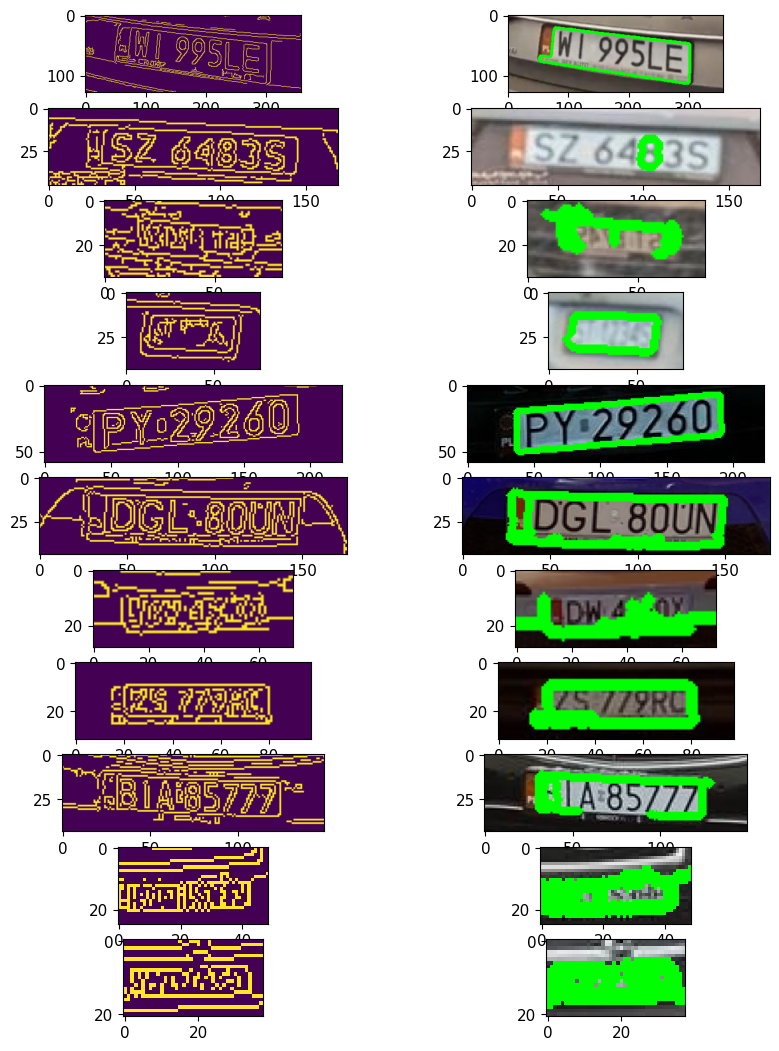

In [ ]:


fig, axs = plt.subplots(len(skewed_plates), 2)
print(len(skewed_plates))

for i, plate in enumerate(skewed_plates):
    
    gray = plate.copy() # cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    

    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150)
    axs[i, 0].imshow(edges)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and pick the largest plausible one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    result = plate.copy()
    
    for j, contour in enumerate(contours):
        cv2.drawContours(result, [contour], -1, (0, 255, 0), 3)
        axs[i, j+1].imshow(result)
        # Approximate the contour to find a quadrilateral
        epsilon = 1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:  # Check if it's a quadrilateral
            license_plate_contour = approx
            break
            
            
        if(not j < 0):
            break

    #if license_plate_contour is not None:
    #    # Draw the contour for visualization
    #    result = plate.copy()
    #    cv2.drawContours(result, [license_plate_contour], -1, (0, 255, 0), 3)
    #    axs[i].imshow(result)
    #    #cv2.imshow("Detected License Plate", result)

    #_, contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #ret, thresh = cv2.threshold(gray, center+20, 255, 0)
    #thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    


11


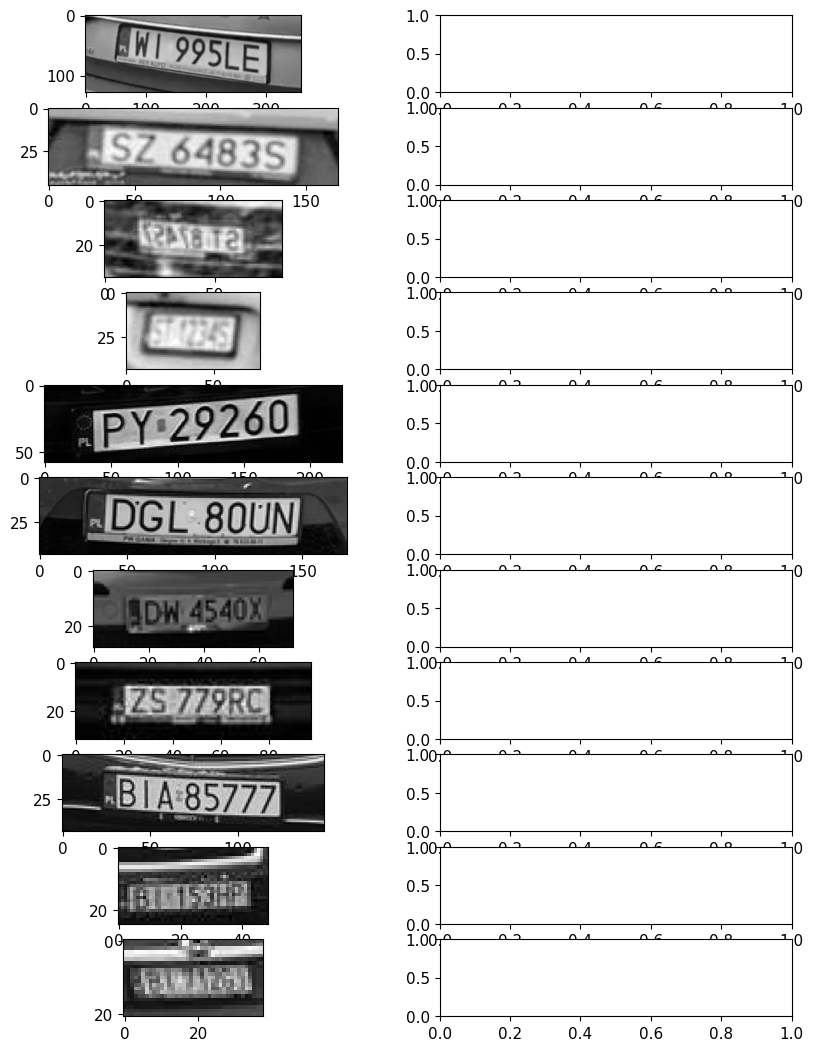

In [129]:


fig, axs = plt.subplots(len(skewed_plates), 2)
print(len(skewed_plates))

for i, plate in enumerate(skewed_plates):
    
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    
    axs[i, 0].imshow(gray, cmap='gray')




11


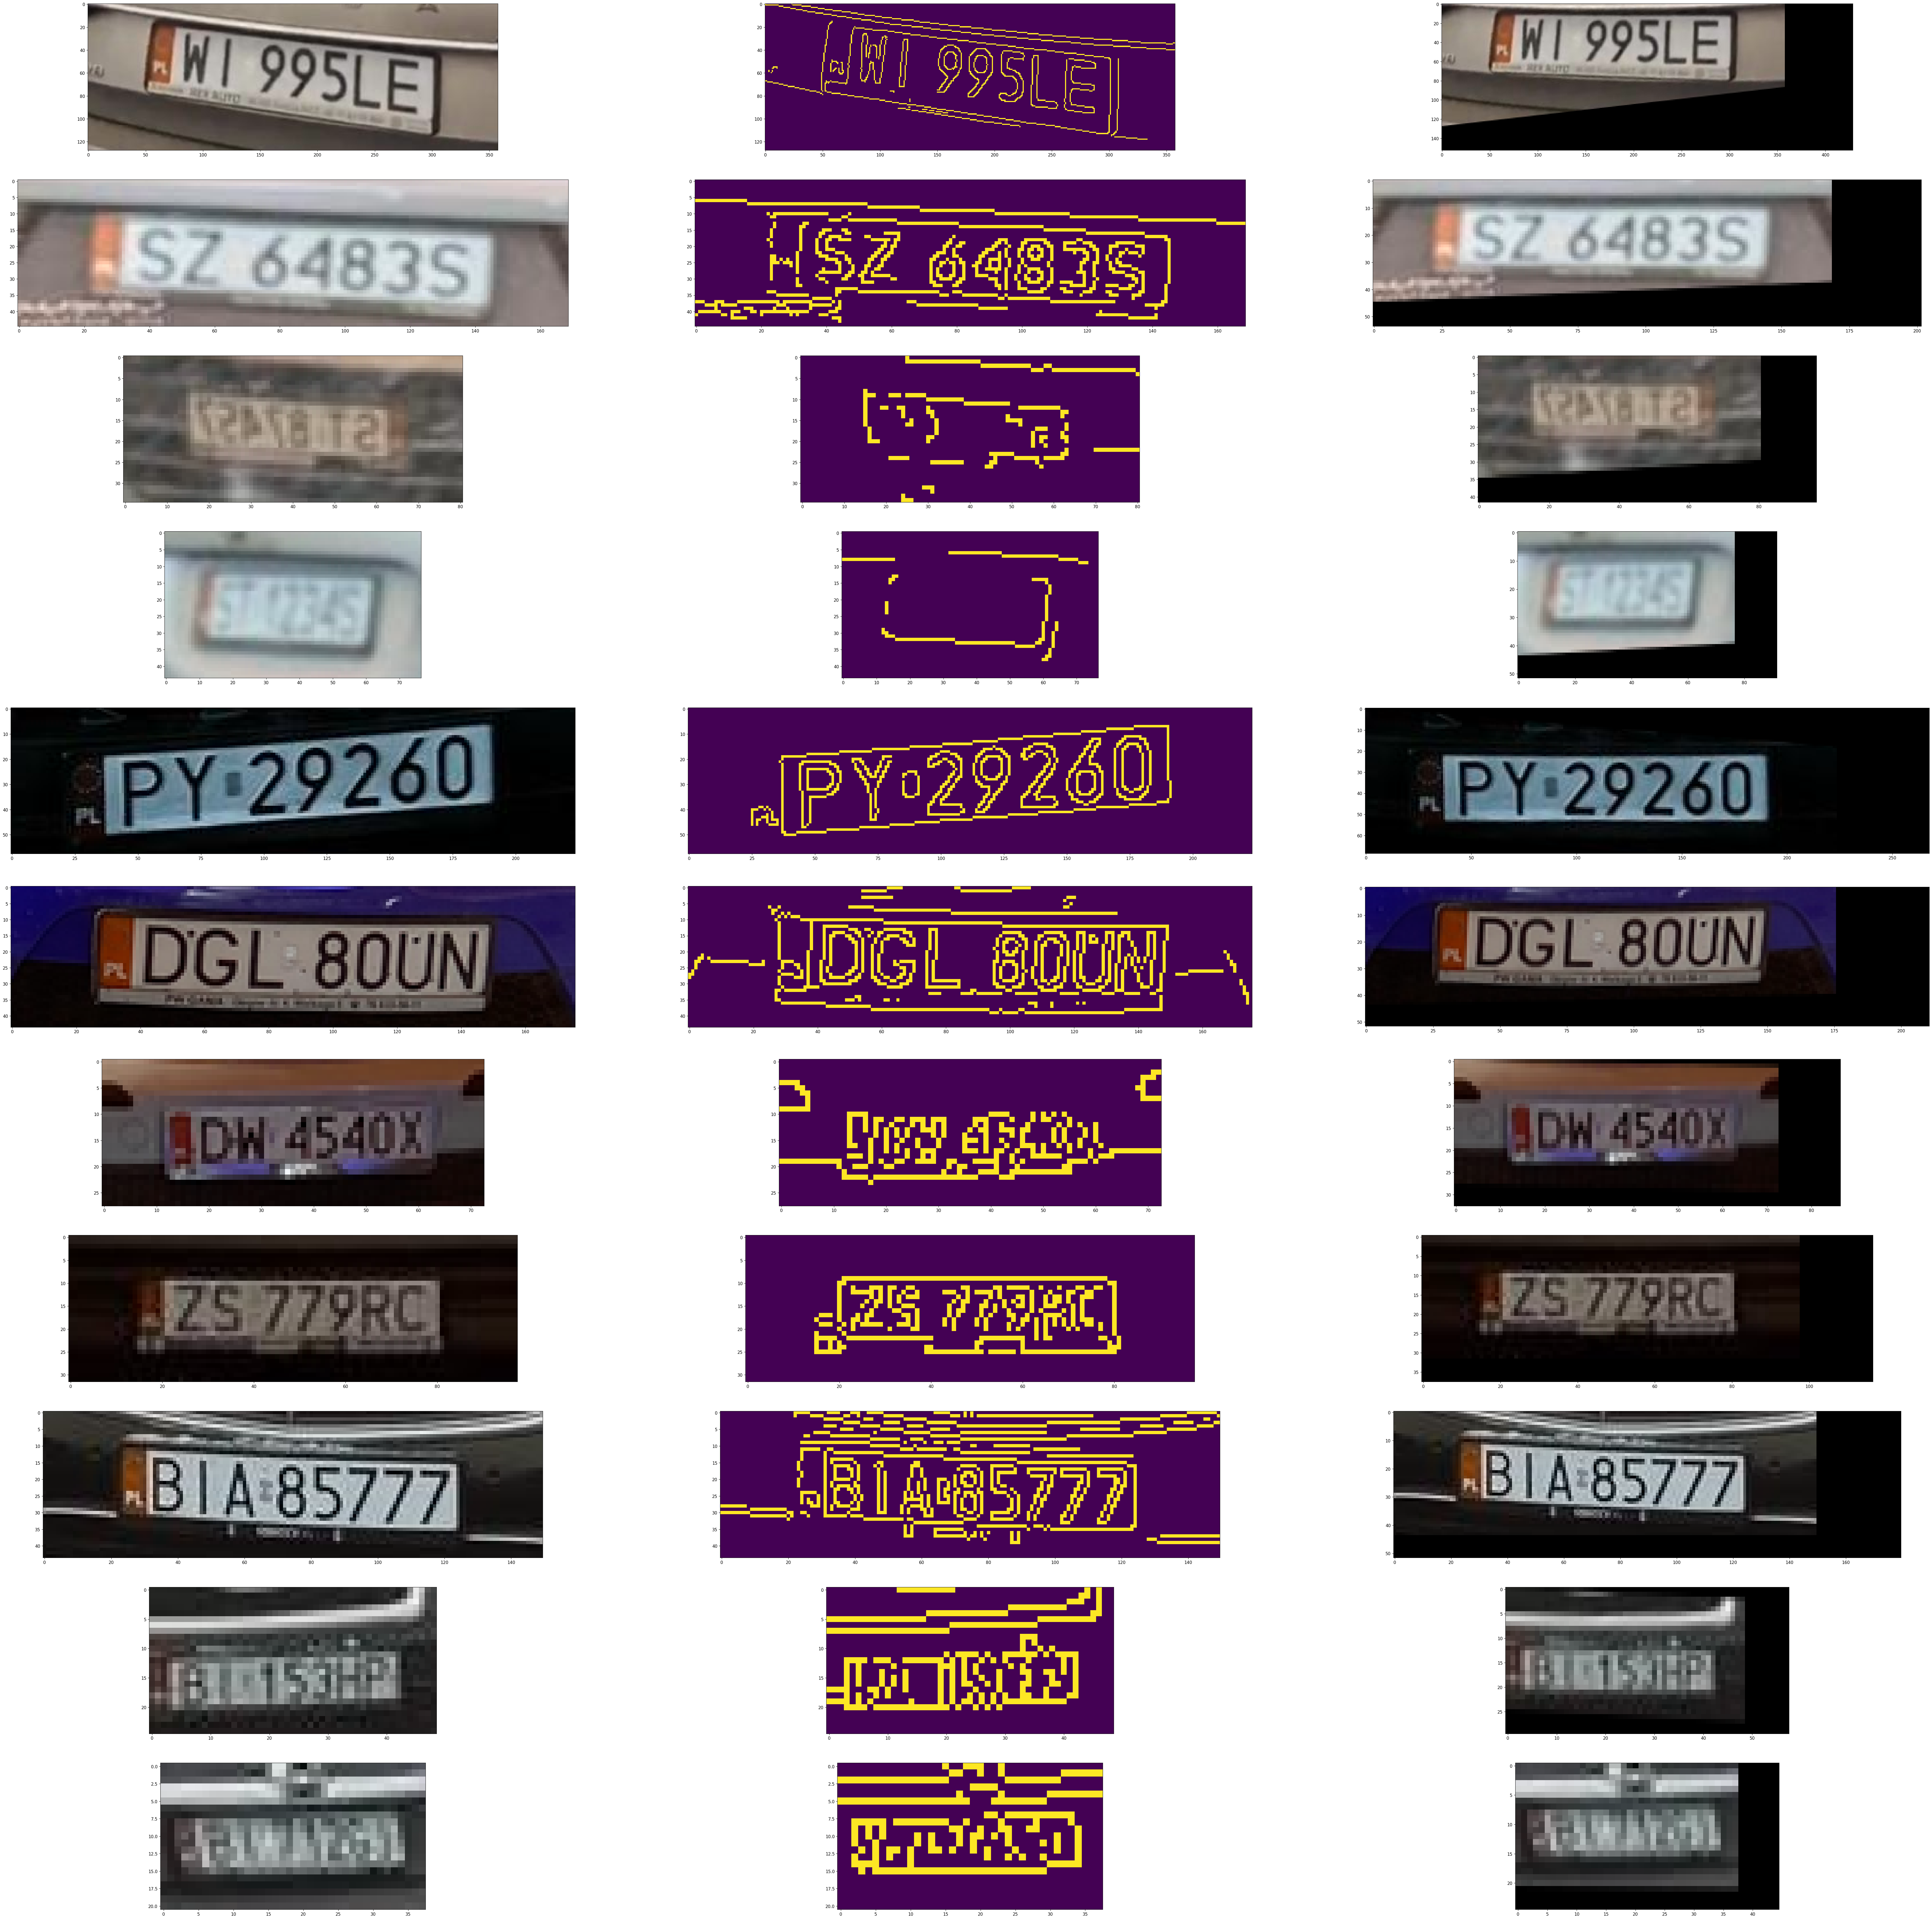

In [ ]:

fig, axs = plt.subplots(len(skewed_plates), 3)
print(len(skewed_plates))
lsd = cv2.createLineSegmentDetector()
plt.rcParams["figure.figsize"] = (90, 90)

rots = []

deskewed = []

for i, plate in enumerate(skewed_plates):
    gray = plate.copy() # cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 200, 255)

    h, w = plate.shape[:2]
    lines = lsd.detect(edges)[0]

    drawn_image = np.copy(plate)        
    lowerLimit = 0.2 * max(h, w)
    
    lengthsAnglesPoints = []
    lengthSum = 0
    for j, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        if(angle < 0):
            angle += 180
        
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        if(x1 > x2):
            x2, x1 = x1, x2
            y2, y1 = y1, y2


        color = tuple(np.random.randint(0, 255, 3).tolist())
        
        if length > lowerLimit and (angle < 10 or (angle < 180 and angle > 170)):
            lengthSum += length
            lengthsAnglesPoints.append((length, angle, [x1, y1, x2, y2]))
            cv2.line(drawn_image, (x1, y1), (x2, y2), color, 1)
            cv2.circle(drawn_image, (x1, y1), 4, color, -1)
        #elif(length > lowerLimit):
        #    print("angle", angle)


    falloff = 0
    for j, (length, angle, (x1, y1, x2, y2)) in enumerate(lengthsAnglesPoints):
        importance = length / lengthSum
        fallCoeff = (y2 - y1) / (x2 - x1)
        falloff += importance * fallCoeff
    
    #angleSum = angleSum / (j+1)
    #print(angleSum)

    x0, y0 = 0, h//2
    x1, y1 = w, h//2
    x1, y1 = w, h//2 + w * falloff
    #else:
    #    x1, y1 = -w*np.cos(angleSum*np.pi/180), -h//2 - h*np.sin(angleSum*np.pi/180)
    
    
    cv2.line(drawn_image, (x0, y0), (int(x1), int(y1)), (0, 255, 0), 1)

    src = np.array([[0, 0], [w, +w*falloff], [w, h + w*falloff], [0, h]], dtype=np.float32)

    dst = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src, dst)
    warp = cv2.warpPerspective(plate, M, (int(w*1.2), int(h*1.2)))
    deskewed.append(warp)

    axs[i, 0].imshow(plate)
    axs[i, 1].imshow(edges)
    axs[i, 2].imshow(warp)
    #axs[i, 2].imshow(drawn_image)
    
        


11


/tmp/ipykernel_32457/1235067125.py:8: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)  # Convert to integer


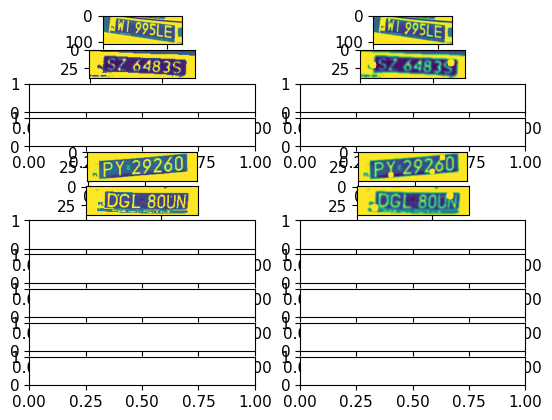

In [102]:

fig, axs = plt.subplots(len(skewed_plates), 2)
print(len(skewed_plates))
for i, plate in enumerate(enchanced):
    
    gray = plate.copy() # cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    corners = cv2.goodFeaturesToTrack(blurred, maxCorners=4, qualityLevel=0.01, minDistance=30)
    corners = np.int0(corners)  # Convert to integer
    
    if corners is None or len(corners) < 4:
        continue
    
    rect = np.zeros((4, 2), dtype="float32")
    corners = corners.reshape(-1, 2)
    s = corners.sum(axis=1)
    diff = np.diff(corners, axis=1)
    
    rect[0] = corners[np.argmin(s)]  # Top-left
    rect[2] = corners[np.argmax(s)]  # Bottom-right
    rect[1] = corners[np.argmin(diff)]  # Top-right
    rect[3] = corners[np.argmax(diff)]  # Bottom-left

    # draw rect on plate
    for j in range(4):
        pos = (int(rect[j][0]), int(rect[j][1]))
        blurred = cv2.circle(blurred, pos, 5, (255, 0, 0), -1)
    axs[i, 0].imshow(plate)
    axs[i, 1].imshow(blurred)

    



Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['N', '995LE']
Recognized Text: N 995LE
['64835']
Recognized Text: 64835
[]
Recognized Text: 
[]
Recognized Text: 
['PY29260']
Recognized Text: PY29260
['DGL 8UN']
Recognized Text: DGL 8UN
['DH 454021']
Recognized Text: DH 454021
['09779r0']
Recognized Text: 09779r0
['"BIA 85777']
Recognized Text: "BIA 85777
[]
Recognized Text: 
[]
Recognized Text: 


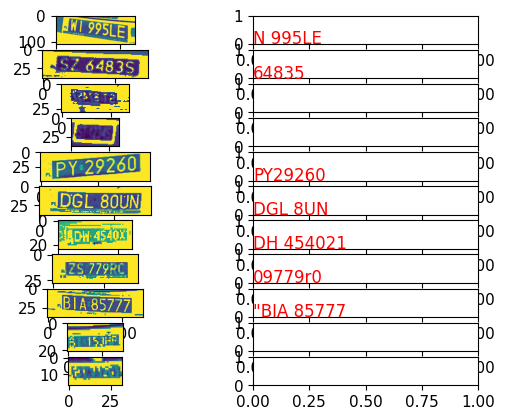

In [103]:
import easyocr
fig, axs = plt.subplots(len(enchanced), 2)
reader = easyocr.Reader(['en'])
for i, plate in enumerate(enchanced):
    plate = plate.copy()
    #plate = cv2.GaussianBlur(plate,(7,7),0)
    ocr_result = reader.readtext(plate, detail=0)
    print(ocr_result)
    print("Recognized Text:", ' '.join(ocr_result))
    axs[i, 0].imshow(plate)
    axs[i, 1].text(0, 0, ' '.join(ocr_result), fontsize=12, color='red')   

In [13]:
import pytesseract # this is tesseract module 
import matplotlib.pyplot as plt 
import cv2 # this is opencv module 
import glob 
import os

In [17]:
for plate in skewed_plates:

    predicted_result = pytesseract.image_to_string(plate, lang ='eng')#, 
    #config ='--oem 3 --psm 6 -c tessedit_char_whitelist = ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789') 
      
    
    print(predicted_result)





2D —S é
> |ADW:4540X,

;

